In [1]:
%matplotlib inline
import torch
from PIL import Image
import os
import glob
import random
import csv
random.seed(4)
import json
import pandas as pd
import numpy as np
import tqdm

import torch
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as transforms

from torchvision.utils import draw_bounding_boxes
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path
#import albumentations as A
import cv2
## A nettoyer

In [2]:
### DEFINITION DES FONCTIONS ###
class ObjectDetectionDataset(Dataset):
    """
    Custom PyTorch Dataset Class to facilitate loading data for the Object Detection Task
    """
    def __init__(self, 
                 path_to_dataset,  
                 mapping = None, 
                 mode = 'train', 
                 transform = None): 
        """ 
        Args:
            annotations: The path to the annotations CSV file. Format: file_name, classes, xmin, ymin, xmax, ymax
            train_test_valid_split: The path to the tags CSV file for train, test, valid split. Format: file_name, tag
            mapping: a dictionary containing mapping of class name and class index. Format : {'class_name' : 'class_index'}, Default: None
            mode: Mode in which to instantiate class. Default: 'train'
            transform: The transforms to be applied to the image data

        Returns:
            image : Torch Tensor, target: Torch Tensor, file_name : str
        """
        self.mapping = mapping
        self.transform = transform
        self.mode = mode

        self.path_to_images = path_to_dataset
        # Loading the annotation file (same format as Remo's)
        
        #my_data = pd.read_csv(annotations)
        
        # Here we append the file path to the filename. 
        # If dataset.export_annotations_to_file was used to create the annotation file, it would feature by default image file paths
        
        #my_data['file_name'] = my_data['file_name'].apply(lambda x : os.path.abspath(f'{self.path_to_images}{x}'))
        #my_data = my_data.set_index('file_name')
        
        annotations_file_path = os.path.join(path_to_dataset, 'annotations.json')
        data = read_file(annotations_file_path)
        my_data  = extractDataSetFromCOCO(data,path_to_dataset)
        my_data['file_name'] = path_to_dataset +  my_data['file_name']
        # Loading the train/test split file (same format as Remo's)
        #my_data['tag'] = pd.read_csv(train_test_valid_split, index_col='file_name')
        
        #my_data = my_data.reset_index()
        # Load only Train/Test/Split depending on the mode
        #my_data = my_data.loc[my_data['tag'] == mode].reset_index(drop=True)
        self.data = my_data

        self.file_names = self.data['file_name'].unique()

    def __len__(self) -> int:
        return self.file_names.shape[0]

    def __getitem__(self, index: int):

        file_name = self.file_names[index]
        records = self.data[self.data['file_name'] == file_name].reset_index()       
        image = np.array(Image.open(file_name), dtype=np.float32)
        image /= 255.0

        if self.transform:
            image = self.transform(image)  

        # here we are assuming we don't have labels for the test set
        if self.mode != 'test':
            boxes = records[['xmin', 'ymin', 'xmax', 'ymax']].values
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            area = torch.as_tensor(area, dtype=torch.float32)

            if self.mapping is not None:
                labels = np.zeros((records.shape[0],))

                for i in range(records.shape[0]):
                    labels[i] = self.mapping[records.loc[i, 'classes']]

                labels = torch.as_tensor(labels, dtype=torch.int64)

            else:
                labels = torch.ones((records.shape[0],), dtype=torch.int64)

            iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

            target = {}
            target['boxes'] = boxes
            target['labels'] = labels
            target['image_id'] = torch.tensor([index])
            target['area'] = area
            target['iscrowd'] = iscrowd 
            target['boxes'] = torch.stack(list((map(torch.tensor, target['boxes'])))).type(torch.float32)

            return image, target, file_name
        else:
            return image, file_name

def collate_fn(batch):
    return tuple(zip(*batch))

def read_file(path_to_file):
    # Read annotations
    with open(path_to_file, 'r') as f:
        dataset = json.loads(f.read())
    return dataset

def extractDataSetFromCOCO(dataset,imagePath):
    """ 
    Args:
        dataset : a parsed JSON file countaining the annotations, must be COCO format.
        imagePath : Path to a file with all the dataSet images.
    Returns:
        df : A pandas dataFrame with the annotations and the image file name
    """
    df = pd.DataFrame()
    categories = [row['name'] for row in dataset['categories']]
    images = [row['file_name'] for row in dataset['images']]
    df['classes'] = [row['category_id'] for row in dataset['annotations']]
    df['file_name'] = [row['image_id'] for row in dataset['annotations']]
    df['file_name'] = [images[i] for i in df['file_name']]
    df['classes'] = [categories[i] for i in df['classes']]
    ## A DELETE ALED
    #df['image'] = [ img_to_array(load_img(imagePath + '/' + fil, target_size=(224, 224))) for fil in df['file_name']] #Très sale, à voir pour faire mieux
    
    df['xmin'] = [row['bbox'][0] for row in dataset['annotations']]
    df['ymin'] = [row['bbox'][1] for row in dataset['annotations']]
    df['xmax'] = [row['bbox'][0]+row['bbox'][2] for row in dataset['annotations']]
    df['ymax'] = [row['bbox'][1]+row['bbox'][3] for row in dataset['annotations']]
    return df

def evaluate(data_loader,device,cat_to_index): 
    """ 
    Args:
        data_loader : A Pytorch dataloader with the images we want to perform detection on.
        device : A Pytorch device, CPU or GPU.
        cat_to_index : A dictionnary linking labels to a int.
    Returns:
        results : List of dictionnary with the bounding boxes, the labels and the scores. It can be easely saved as csv or json.
    """
    mapping = { value : key for (key, value) in cat_to_index.items()}
    detection_threshold = 0.3
    results = []
    model.eval()
    data_loader = tqdm.tqdm(data_loader)

    with torch.no_grad():
        for images, image_ids in data_loader:

            images = list(image.to(device) for image in images)
            outputs = model(images)
            for i, image in enumerate(images):

                boxes = outputs[i]['boxes'].data.cpu().numpy()
                scores = outputs[i]['scores'].data.cpu().numpy()
                boxes = boxes[scores >= detection_threshold].astype(np.int32)
                scores = scores[scores >= detection_threshold]
                image_id = image_ids[i]

                for box, labels,score in zip(boxes, outputs[i]['labels'],scores):
                    results.append({'file_name' : os.path.basename(image_id), 
                                    'classes'   : mapping[labels.item()], 
                                    'xmin'      : box[0],
                                    'ymin'      : box[1],
                                    'xmax'      : box[2],
                                    'ymax'      : box[3],
                                    'scores'    : score})
    return results
        
def convert_points_to_box(points, color = 'red', alpha = 0.09):
    '''
        Helper Function : return two pyplot.Rectangle for the purpous of plotting bboxes. One is the border and one is the fill color.
    '''
    upper_left_point = (points[0], points[1])
    width = points[2] - points[0]
    height = points[3] - points[1]
    return (plt.Rectangle(upper_left_point, width, height, ec=color,fc=color, alpha=1,facecolor='none',fill = False),plt.Rectangle(upper_left_point, width, height, ec=color,fc=color, alpha=alpha))

def show_bounding_boxes(img,l_boxes,l_scores = None,labels = None,fontsize = 16):
    '''
        Show the bounding boxes in l_boxes for a specified image img in np.array format. 
    '''
    fig = plt.figure(figsize=(25, 10))
    colors = ['red','blue']
    ax = plt.gca()
    colors_idx = [random.randint(0, len(colors)-1) for i in l_boxes]
    plt.imshow(img)
    for i,box in enumerate(l_boxes):
        contour,texture = convert_points_to_box(box, colors[colors_idx[i]], 0.1)
        ax.add_patch(contour)
        ax.add_patch(texture)
        if labels and l_scores:
            plt.text(box[0],box[1],labels[i] + " : "+ str(np.round_(100*l_scores[i], decimals=2))+ " %",fontsize=fontsize,color =colors[colors_idx[i]] )

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    plt.show()
    
def show_result(results,path_to_dataset,file_name):
    '''
        Show the bounding boxes in l_boxes for a specified image img in np.array format. 
    '''
    img = plt.imread(path_to_dataset + "/" + file_name)
    l_boxes = []
    l_labels = []
    l_scores = []
    for row in results:
        if row['file_name'] == file_name:
            l_boxes.append([row['xmin'],row['ymin'],row['xmax'],row['ymax']])
            l_labels.append(row['classes'])
            l_scores.append(row['scores'])
    print("Nombre de déchets identifiés : ", len(l_boxes))
    show_bounding_boxes(img,l_boxes,l_scores = l_scores,labels = l_labels)

In [3]:
### Parametrisation ###

model_path = "../saved_models/model3SGD"
path_to_data = '../dataset/dataset_Trashedy_1.0/valid/'
device      = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
cat_to_index = {'other': 1, 
                'pet': 2,
                'eps-polystyrene-': 3, 
                'plastic_bag' : 4 
                }

In [4]:


tensor_transform = transforms.Compose([transforms.ToTensor()])

dataset = ObjectDetectionDataset(path_to_dataset = path_to_data,  
                                       transform = tensor_transform,
                                       mapping = cat_to_index,
                                       mode = 'test')

data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [5]:
model = torch.load(model_path)

In [6]:
results = evaluate(data_loader,device,cat_to_index)
print("Fin de l'évaluation")

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]C:\Users\diabo\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [02:20<00:00,  4.52s/it]

Fin de l'évaluation


29 Images avec 133 objets detectés
Entrer indice de l'image à afficher : 26
Nombre de déchets identifiés :  1


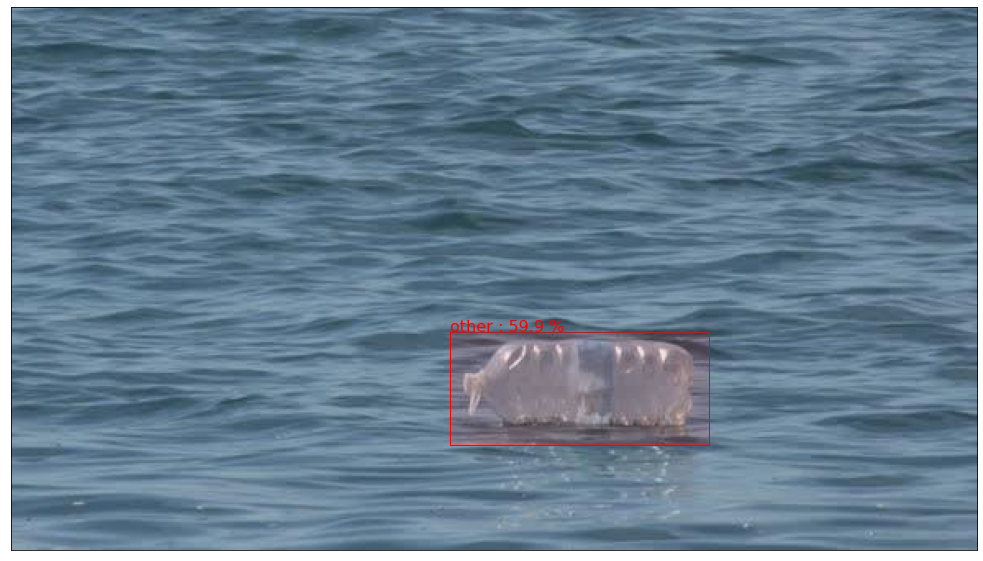

In [7]:
l_file_name = np.unique([row['file_name'] for row in results])
n_file_name = len(l_file_name)
n_objects = len(results)
print("{} Images avec {} objets detectés".format(n_file_name,n_objects))
idx = int(input("Entrer indice de l'image à afficher : "))
show_result(results,path_to_data , l_file_name[idx])

In [8]:
### COMBAT ZONE ###

from bbaug import policies

item = dataset_experiment.__getitem__(0)

image = item[0].permute(1,2,0)
labels = item[1]['labels']
bounding_boxes = item[1]['boxes']
show_bounding_boxes(image,bounding_boxes,labels = labels,fontsize = 16)
# select policy v0 set
aug_policy = policies.policies_v0()
 
# instantiate the policy container with the selected policy set
policy_container = policies.PolicyContainer(aug_policy)

# select a random policy from the policy set
random_policy = policy_container.select_random_policy() 

# Apply the augmentation. Returns the augmented image and bounding boxes.
# Image is a numpy array of the image
# Bounding boxes is a list of list of bounding boxes in pixels (int).
# e.g. [[x_min, y_min, x_man, y_max], [x_min, y_min, x_man, y_max]]
# Labels are the class labels for the bounding boxes as an iterable of ints e.g. [1,0]
img_aug, bbs_aug = policy_container.apply_augmentation(random_policy, image, bounding_boxes, labels)

ModuleNotFoundError: No module named 'bbaug'